In [1]:
import numpy as np
import sys
import time
import random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

sys.path.append('/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm')

%load_ext autoreload
%autoreload 2

In [2]:
from word2vec_eltdm.word2vec_numpy import (
    Tokenizer, VocabCreator, DataLoader, TokenCleaner, Preprocessor,
    Subsampler, SimpleWord2Vec, Optimizer, CrossEntropy, train, validate
)

## Get data and create vocab

In [3]:
datapath = "../data/text8.txt"

RATIO = 0.10
tokenizer = Tokenizer(datapath)
token_cleaner = TokenCleaner(freq_threshold=5)
vocab_creator = VocabCreator()
text8_dataset = Preprocessor(tokenizer, token_cleaner, vocab_creator, RATIO).preprocess()

In [4]:
print("Size of our vocabulary:", len(text8_dataset.tokens_to_id))

Size of our vocabulary: 16778


In [5]:
print("Number of tokens in our train dataset:", len(text8_dataset.train_tokens))

Number of tokens in our train dataset: 794731


In [6]:
print("Number of tokens in our val dataset:", len(text8_dataset.val_tokens))

Number of tokens in our val dataset: 99341


In [7]:
print("Number of tokens in our test dataset:", len(text8_dataset.test_tokens))

Number of tokens in our test dataset: 99342


## Subsampling of frequent words, as in Mikolov 2013.

In [8]:
subsampler = Subsampler(text8_dataset.train_tokens)
text8_dataset.train_tokens, text8_dataset.frequencies = subsampler.subsample()

In [9]:
print("Size of our vocabulary after subsampling of frequent words, for train:", len(text8_dataset.tokens_to_id))

Size of our vocabulary after subsampling of frequent words, for train: 16778


In [10]:
print("Number of tokens in train dataset:", len(text8_dataset.train_tokens))

Number of tokens in train dataset: 228859


## DataLoader

In [11]:
window = 5
batch_size = 256
train_dataloader = DataLoader(text8_dataset, text8_dataset.train_tokens, window, batch_size)
val_dataloader = DataLoader(text8_dataset, text8_dataset.val_tokens, window, batch_size)
test_dataloader = DataLoader(text8_dataset, text8_dataset.test_tokens, window, batch_size)

In [12]:
start = time.perf_counter()
for batch in tqdm(train_dataloader):
    X, y = batch["X"], batch["Y"]
end = time.perf_counter()
print(f"Lopped through all the training dataset in {end - start:0.4f} seconds")

  0%|          | 0/893 [00:00<?, ?it/s]

Lopped through all the training dataset in 0.6717 seconds


## Model

In [13]:
# defining the parameters
len_vocab = len(text8_dataset.tokens_to_id)
hidden_size = 500
embedding_size = 300
learning_rate = 1e-3

# instantiate the model
model = SimpleWord2Vec(
    len_vocab,
    hidden_size,
    embedding_size
)
model.initialize_weights()
#model.initialize_embeddings()

# using the loss that we defined
criterion = CrossEntropy() 
optimizer = Optimizer(model,learning_rate)

## Training

In [14]:
# train for some number of epochs
epochs = 5
train_loss_history = []
val_loss_history = []
tbar = trange(epochs)
for epoch in tbar:
    print(f"###################### EPOCH {epoch} ###########################")
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer)
    print("Training loss:", train_loss)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    #if epoch % 2 == 0:
    #    validation_loss = validate(model, val_dataloader, criterion)
    #    print("Validation loss:", validation_loss)
    #    val_loss_history.append(validation_loss)

  0%|          | 0/5 [00:00<?, ?it/s]

###################### EPOCH 0 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 6.84973


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  6.849833230414729
Training loss: 6.849868774667971
###################### EPOCH 1 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 6.84978


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  6.849829412801067
Training loss: 6.849866609026265
###################### EPOCH 2 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 6.84966


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  6.849822288916732
Training loss: 6.849858518290941
###################### EPOCH 3 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 6.84984


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  6.84981131608127
Training loss: 6.849849947720825
###################### EPOCH 4 ###########################


  0%|          | 0/893 [00:00<?, ?it/s]

Current Training Loss 6.8498


  0%|          | 0/388 [00:00<?, ?it/s]

Validation Loss:  6.849808642673937
Training loss: 6.849845165259696


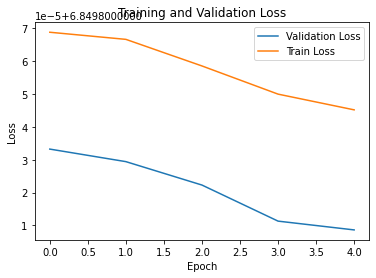

In [15]:
plt.plot(val_loss_history, label = "Validation Loss")
plt.plot(train_loss_history, label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend() 
plt.title('Training and Validation Loss')
plt.show() 

In [16]:
print(model.best_W1)

[[-0.09415765  0.0473524  -0.02799146 ...  0.01955824  0.02215764
   0.03412403]
 [-0.00201228 -0.01045619  0.06839272 ... -0.02466096  0.044828
  -0.0298562 ]
 [-0.0331256  -0.00610306 -0.07583676 ... -0.11243981  0.00779486
   0.12967933]
 ...
 [-0.05527923 -0.02853435 -0.02608069 ...  0.09009356 -0.0346077
  -0.01745409]
 [ 0.05510035  0.06385517 -0.08241432 ... -0.18284859 -0.0827512
  -0.05020243]
 [ 0.03511108 -0.09622157  0.00207658 ...  0.05110389  0.01671565
  -0.01070944]]


In [17]:
print(model.best_W2)

[[ 0.03724333  0.06571376  0.18461144 ... -0.03109954  0.00233011
   0.05025596]
 [ 0.00171752  0.01134107  0.05892988 ... -0.00911774 -0.05571263
  -0.04207262]
 [ 0.01751853 -0.04387989 -0.03041018 ...  0.0525565  -0.05529184
  -0.07878087]
 ...
 [-0.09253175 -0.00597768 -0.04434807 ...  0.03792593 -0.07520217
   0.06037898]
 [ 0.05630487  0.06907755 -0.02474062 ... -0.02178137 -0.05140625
  -0.09466186]
 [ 0.09187098  0.08290006  0.02604258 ... -0.00064334 -0.02149797
   0.02073852]]


## Results on test set